In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from numba import jit, float64, prange
from numba.experimental import jitclass

In [2]:
# Suppose the code below is data representing the wealth of 100,000 households
n = 10_000                      # size of sample
w = np.exp(np.random.randn(n))  # lognormal draws

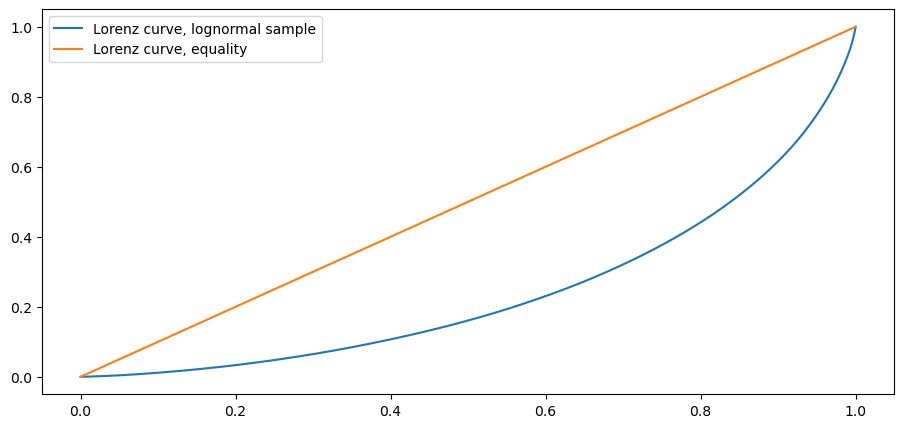

In [3]:
# Let's compute and plot the Lorenz curve
f_vals, l_vals = qe.lorenz_curve(w)

fig, ax = plt.subplots()
ax.plot(f_vals, l_vals, label='Lorenz curve, lognormal sample')
ax.plot(f_vals, f_vals, label='Lorenz curve, equality')
ax.legend()
plt.show()


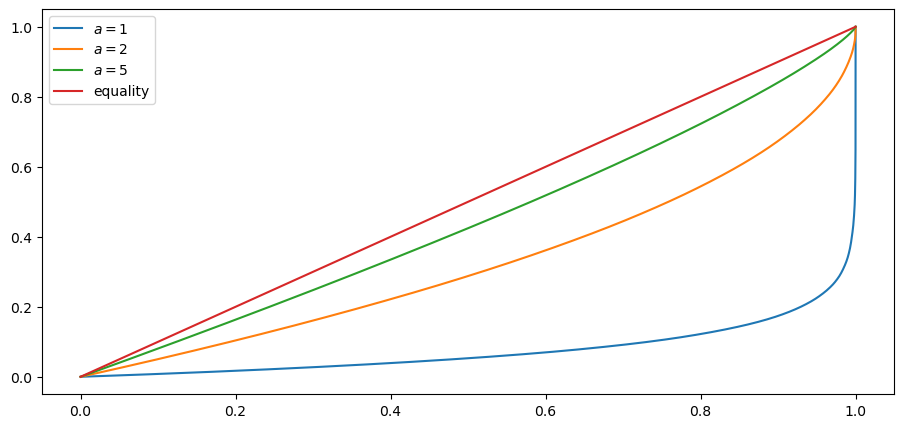

In [4]:
# We see how the Lorenz curve shifts as underlying distribution changes. 
# We generate 10,000 observations using the Pareto distribution with a range of parameters, and then compute the Lorenz curve corresponding to each set of observations.
a_vals = (1, 2, 5)              # Pareto tail index
n = 10_000                      # size of each sample
fig, ax = plt.subplots()
for a in a_vals:
    u = np.random.uniform(size=n)
    y = u**(-1/a)               # distributed as Pareto with tail index a
    f_vals, l_vals = qe.lorenz_curve(y)
    ax.plot(f_vals, l_vals, label=f'$a = {a}$')
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

In [5]:
# We can see that, as the tail parameter of the Pareto distribution increases, inequality decreases.
# This is expected, as a higher tail index implies less weight in the tail of the Pareto distribution.


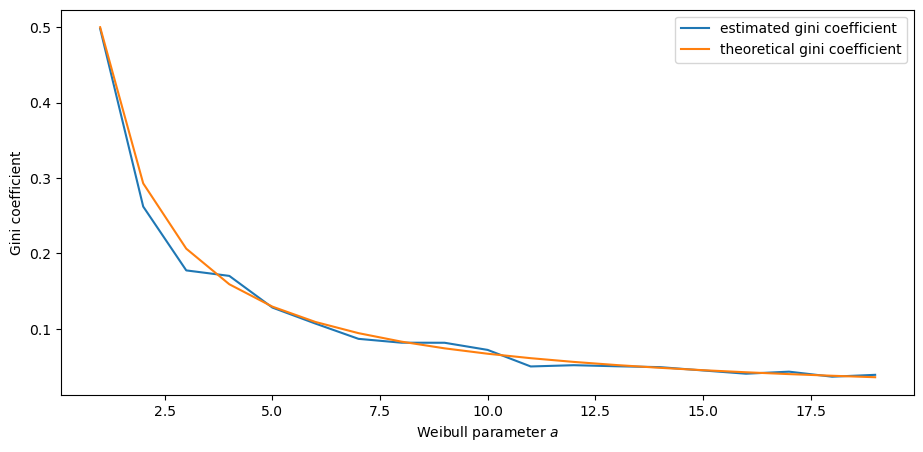

In [6]:
# Let's see if f the Gini coefficient computed from a simulated sample matches this at each fixed value of a
a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 100

fig, ax = plt.subplots()
for a in a_vals:
    y = np.random.weibull(a, size=n)
    ginis.append(qe.gini_coefficient(y))
    ginis_theoretical.append(1 - 2**(-1/a))
ax.plot(a_vals, ginis, label='estimated gini coefficient')
ax.plot(a_vals, ginis_theoretical, label='theoretical gini coefficient')
ax.legend()
ax.set_xlabel("Weibull parameter $a$")
ax.set_ylabel("Gini coefficient")
plt.show()

In [7]:
# Good fit.

In [8]:
# A Model Of Wealth Dynamics ( Model specifications outlined in project description)
wealth_dynamics_data = [
    ('w_hat',  float64),    # savings parameter
    ('s_0',    float64),    # savings parameter
    ('c_y',    float64),    # labor income parameter
    ('μ_y',    float64),    # labor income paraemter
    ('σ_y',    float64),    # labor income parameter
    ('c_r',    float64),    # rate of return parameter
    ('μ_r',    float64),    # rate of return parameter
    ('σ_r',    float64),    # rate of return parameter
    ('a',      float64),    # aggregate shock parameter
    ('b',      float64),    # aggregate shock parameter
    ('σ_z',    float64),    # aggregate shock parameter
    ('z_mean', float64),    # mean of z process
    ('z_var', float64),     # variance of z process
    ('y_mean', float64),    # mean of y process
    ('R_mean', float64)     # mean of R process
]

In [9]:
# We construct a class that stores instance data and implements methods that update the aggregate state and household wealth.
@jitclass(wealth_dynamics_data)
class WealthDynamics:

    def __init__(self,
                 w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1):

        self.w_hat, self.s_0 = w_hat, s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r, self.σ_r = c_r, μ_r, σ_r
        self.a, self.b, self.σ_z = a, b, σ_z

        # Record stationary moments
        self.z_mean = b / (1 - a)
        self.z_var = σ_z**2 / (1 - a**2)
        exp_z_mean = np.exp(self.z_mean + self.z_var / 2)
        self.R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
        self.y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)

        # Test a stability condition that ensures wealth does not diverge
        # to infinity.
        α = self.R_mean * self.s_0
        if α >= 1:
            raise ValueError("Stability condition failed.")

    def parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.w_hat, self.s_0,
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r, self.σ_r,
                      self.a, self.b, self.σ_z)
        return parameters

    def update_states(self, w, z):
        """
        Update one period, given current wealth w and persistent
        state z.
        """

        # Simplify names
        params = self.parameters()
        w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, a, b, σ_z = params
        zp = a * z + b + σ_z * np.random.randn()

        # Update wealth
        y = c_y * np.exp(zp) + np.exp(μ_y + σ_y * np.random.randn())
        wp = y
        if w >= w_hat:
            R = c_r * np.exp(zp) + np.exp(μ_r + σ_r * np.random.randn())
            wp += R * s_0 * w
        return wp, zp


In [10]:
# A function to simulate the time series of wealth for in individual households.
@jit
def wealth_time_series(wdy, w_0, n):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: an instance of WealthDynamics
        * w_0: scalar
        * n: int


    """
    z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1], z = wdy.update_states(w[t], z)
    return w

In [11]:
# A function to simulate a cross section of households forward in time.
@jit(parallel=True)
def update_cross_section(wdy, w_distribution, shift_length=500):
    """
    Shifts a cross-section of household forward in time

    * wdy: an instance of WealthDynamics
    * w_distribution: array_like, represents current cross-section

    Takes a current distribution of wealth values as w_distribution
    and updates each w_t in w_distribution to w_{t+j}, where
    j = shift_length.

    Returns the new distribution.

    """
    new_distribution = np.empty_like(w_distribution)

    # Update each household
    for i in prange(len(new_distribution)):
        z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
        w = w_distribution[i]
        for t in range(shift_length-1):
            w, z = wdy.update_states(w, z)
        new_distribution[i] = w
    return new_distribution

In [12]:
# Applications: We try simulating the model at different parameter values and investigate the implications for the wealth distribution.


In [13]:
#1. Time Series: Let’s look at the wealth dynamics of an individual household.
wdy = WealthDynamics()
ts_length = 200
w = wealth_time_series(wdy, wdy.y_mean, ts_length)

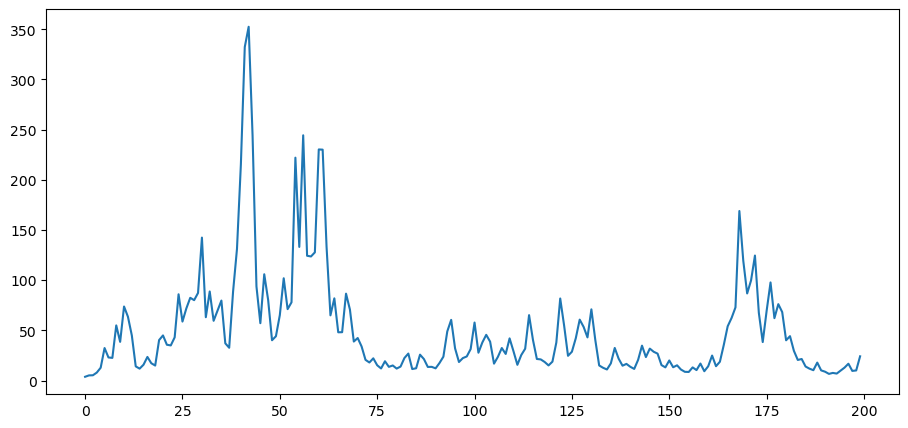

In [14]:
fig, ax = plt.subplots()
ax.plot(w)
plt.show()

In [15]:
# Large spikes in wealth over time.

In [16]:
# 2. Inequality Measures: Let’s look at how inequality varies with returns on financial assets.
# The next function generates a cross section and then computes the Lorenz curve and Gini coefficient.
def generate_lorenz_and_gini(wdy, num_households=100_000, T=500):
    """
    Generate the Lorenz curve data and gini coefficient corresponding to a
    WealthDynamics mode by simulating num_households forward to time T.
    """
    ψ_0 = np.full(num_households, wdy.y_mean)
    z_0 = wdy.z_mean

    ψ_star = update_cross_section(wdy, ψ_0, shift_length=T)
    return qe.gini_coefficient(ψ_star), qe.lorenz_curve(ψ_star)

In [24]:
# Now, we take a look at how the Lorenz curves associated with the wealth distribution change as return to savings varies.


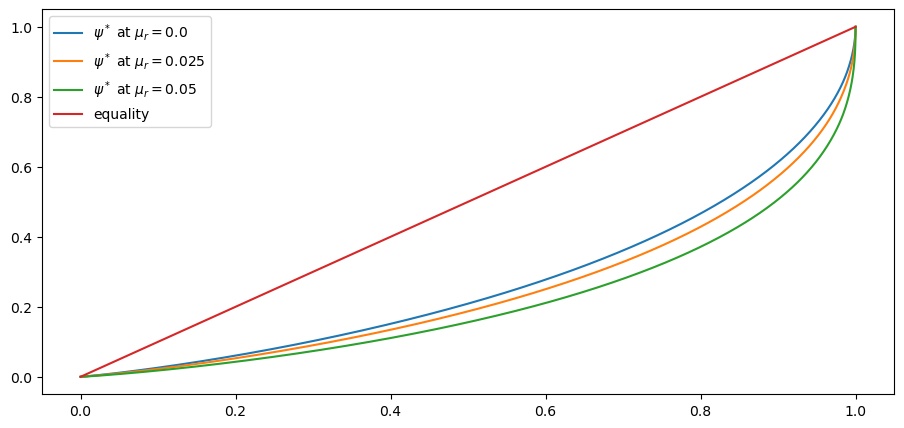

CPU times: total: 48.1 s
Wall time: 5.71 s


In [26]:
%%time

fig, ax = plt.subplots()
μ_r_vals = (0.0, 0.025, 0.05)
gini_vals = []

for μ_r in μ_r_vals:
    wdy = WealthDynamics(μ_r=μ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wdy)
    ax.plot(f_vals, l_vals, label=fr'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='equality')
ax.legend(loc="upper left")
plt.show()

In [ ]:
# We see that Lorenz curve shifts downwards as returns on financial income rise, indicating a rise in inequality. We  check the same for Gini coefficient below.


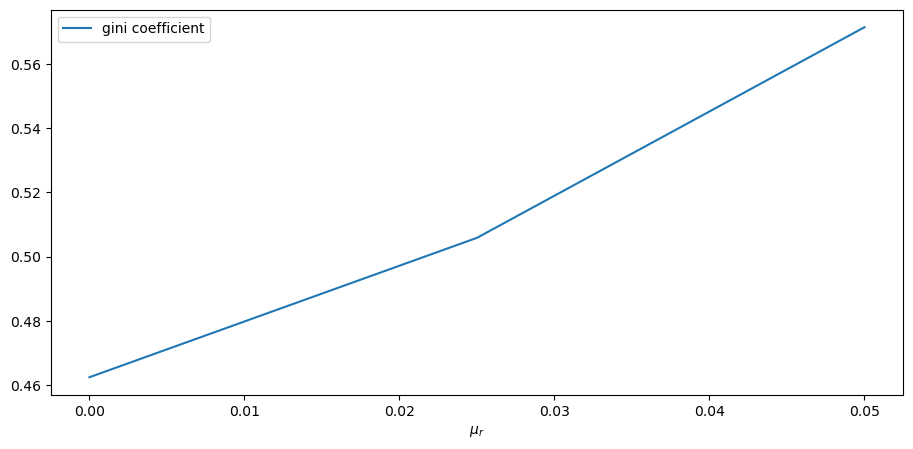

In [28]:
fig, ax = plt.subplots()
ax.plot(μ_r_vals, gini_vals, label='gini coefficient')
ax.set_xlabel(r"$\mu_r$")
ax.legend()
plt.show()

In [ ]:
# Results stay same.

In [ ]:
# We now take a look at what happens when we change the volatility term sigma_r in financial returns.


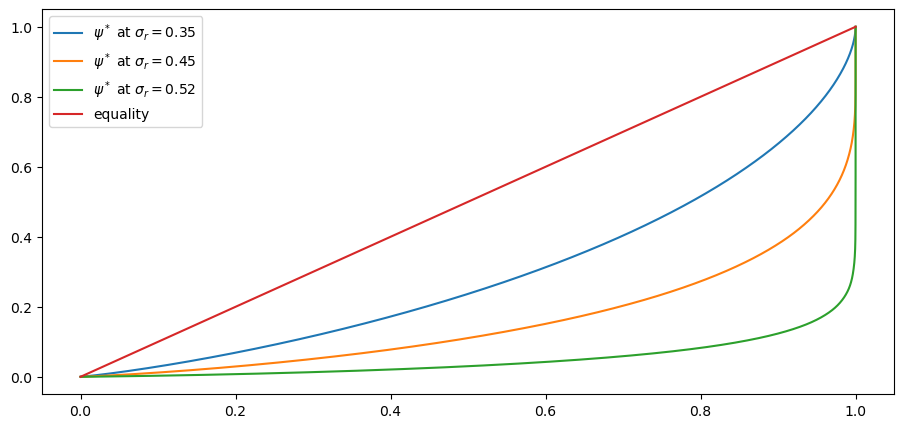

CPU times: total: 49.5 s
Wall time: 5.12 s


In [30]:
%%time

fig, ax = plt.subplots()
σ_r_vals = (0.35, 0.45, 0.52)
gini_vals = []

for σ_r in σ_r_vals:
    wdy = WealthDynamics(σ_r=σ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wdy)
    ax.plot(f_vals, l_vals, label=fr'$\psi^*$ at $\sigma_r = {σ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='equality')
ax.legend(loc="upper left")
plt.show()

In [ ]:
# Greater the volatility, higher the inequality.